In [1]:
# from cityscapesscripts.download import downloader
import torch
from PIL import Image
import json
import glob
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models.segmentation as segmentation


from utility import CityscapeSegTemp, plot_samples, calculate_iou


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)  
elif torch.backends.mps.is_available():  # Check for M1 GPU availability
    device = torch.device("mps")  # M1 GPU
    gpu_name = "Apple M1"
else:
    device = torch.device("cpu")
    gpu_name = "CPU"

print(f"Using device: {device}, GPU: {gpu_name}")

Using device: cuda, GPU: NVIDIA GeForce RTX 4090


In [4]:
train_dataset = CityscapeSegTemp(root_dir='./data', split='train', device = device)
val_dataset =   CityscapeSegTemp(root_dir='./data', split='val', device= device)


batch_size = 8 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


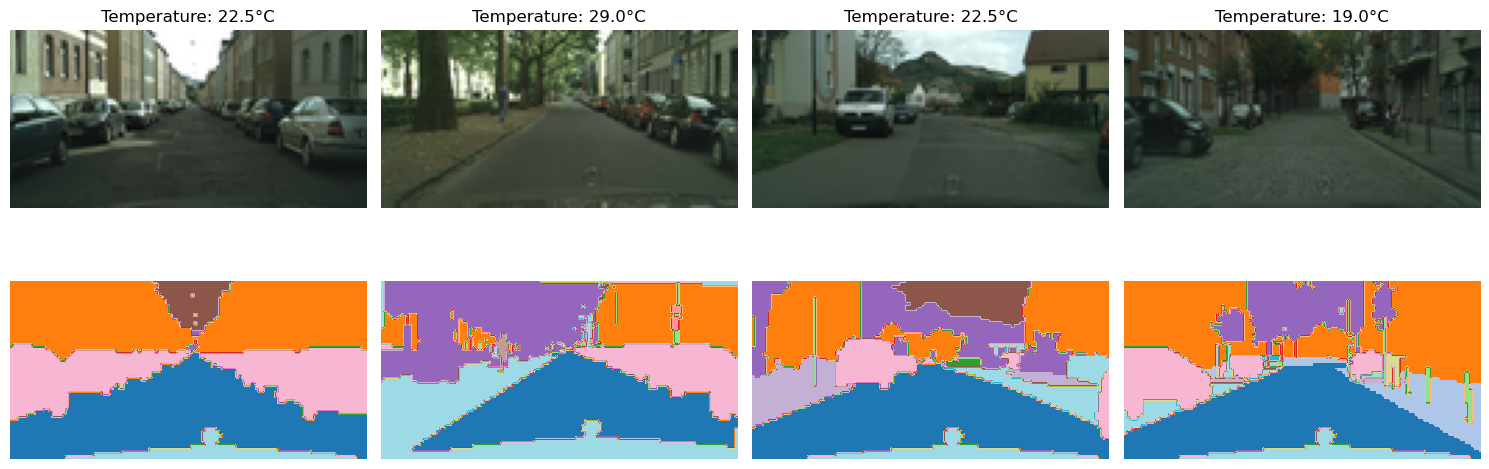

In [5]:
plot_samples(train_loader)

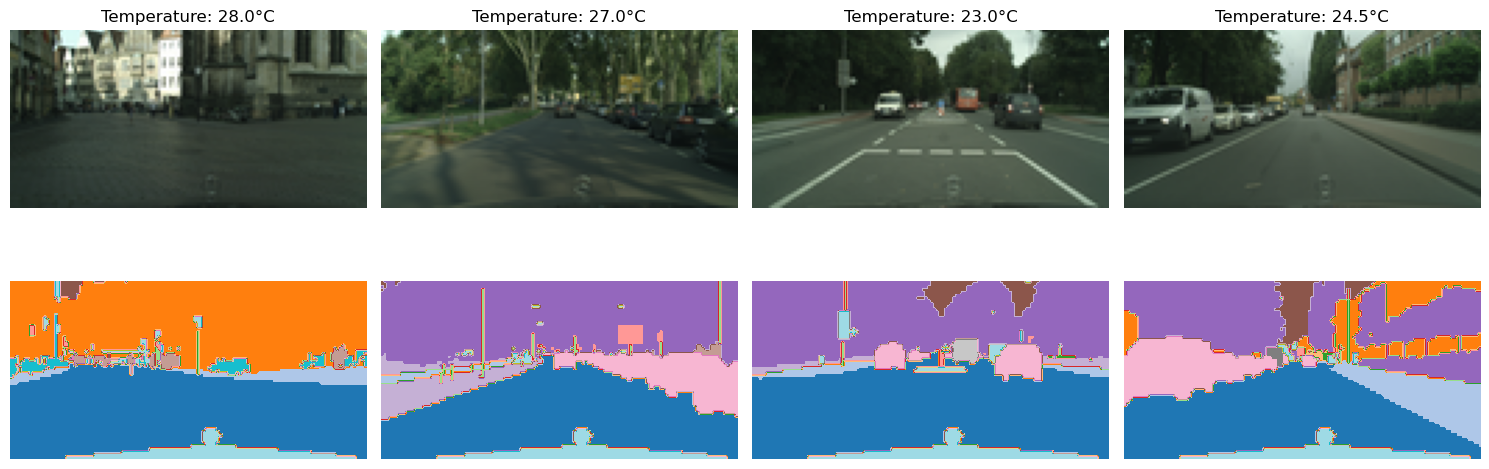

In [6]:
plot_samples(val_loader)

In [7]:
unique_mask_values = set()

for i in range(20):
    _, (mask, _) = train_dataset[i]  # Assuming this is how your dataset returns values
    unique_values = torch.unique(mask).tolist()  # Convert to a list of values
    unique_mask_values.update(unique_values)  # Update the set with new unique values

print(f'Unique mask values in the dataset: {unique_mask_values}')
print(f'Total: {len(unique_mask_values)}')

Unique mask values in the dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19}
Total: 19


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if stride != 1 or in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)
        return out

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsampleBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ResidualBlock(out_channels * 2, out_channels)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class ResidualUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResidualUNet, self).__init__()
        self.encoder1 = ResidualBlock(3, 64)
        self.encoder2 = ResidualBlock(64, 128, stride=2) # 1/2
        self.encoder3 = ResidualBlock(128, 256, stride=2) # 1/4
        self.encoder4 = ResidualBlock(256, 512, stride=2) # 1/8
        # self.bridge = ResidualBlock(512, 1024, stride=2) # 1/16

        # self.upsample1 = UpsampleBlock(1024, 512)
        self.upsample2 = UpsampleBlock(512, 256)
        self.upsample3 = UpsampleBlock(256, 128)
        self.upsample4 = UpsampleBlock(128, 64)

        self.mask_output = nn.Conv2d(64, num_classes, kernel_size=1)
        self.temp_output = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        # bridge = self.bridge(enc4)

        # up1 = self.upsample1(bridge, enc4)
        up2 = self.upsample2(enc4, enc3)
        up3 = self.upsample3(up2, enc2)
        up4 = self.upsample4(up3, enc1)

        mask = self.mask_output(up4)
        temp = self.temp_output(up4) 

        return mask, temp

In [9]:
num_classes = 19
model = ResidualUNet(num_classes)
model = model.to(device)

log_interval = 20

train_loss = []


val_loss = []

optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(epoch):
    model.train()
    train_running_loss = 0.0

    train_iou = []

    for batch_idx, (images, (masks, temperatures)) in enumerate(train_loader):
        images, masks, temperatures = images, masks, temperatures

        optimizer.zero_grad()
        output_masks, output_temps = model(images)

        mask_loss = F.cross_entropy(output_masks, masks.long(), ignore_index=19)  
        temp_loss = F.mse_loss(output_temps.squeeze(), temperatures.float()) 
        
        # Combine losses and backpropagate
        total_loss = mask_loss + temp_loss*0.1
        total_loss.backward()
        optimizer.step()

        train_running_loss += total_loss.item()  # Update running loss

        iou_batch = calculate_iou(output_masks, masks, num_classes)
        train_iou.extend(iou_batch)

        # Logging
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {total_loss.item():.3f}\t'
                  f'Mask Loss: {mask_loss.item():.3f}, Temp Loss: {temp_loss.item():.3f}')

    # Calculate average training loss for the epoch
    train_epoch_loss = train_running_loss / len(train_loader.dataset)
    mean_iou_train = sum(train_iou) / len(train_iou)
    print(f'Train Epoch Loss: {train_epoch_loss:.3f} ------ Mask Loss: {mask_loss.item():.3f} ---- Temp Loss: {temp_loss.item():.3f} ---- Mean IOU: {mean_iou_train:.3f}')
    train_loss.append(train_epoch_loss)



def validation():
    model.eval()
    val_running_loss = 0.0
    mask_loss = 0.0  
    temp_loss = 0.0 
    val_iou = []

    with torch.no_grad():  # Disable gradient calculation during validation
        for images, (masks, temperatures) in val_loader:

            images, masks, temperatures = images, masks, temperatures
            output_masks, output_temps = model(images)

            mask_loss += F.cross_entropy(output_masks, masks.long(), ignore_index=19, reduction = 'sum').item() 

            temp_loss += F.mse_loss(output_temps.squeeze(), temperatures.float(), reduction='mean').item()   

            iou_batch = calculate_iou(output_masks, masks, num_classes)
            val_iou.extend(iou_batch)
    
            
        
        val_running_loss = mask_loss + temp_loss*0.1
        # val_running_loss += total_loss.item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    mean_iou_val = sum(val_iou) / len(val_iou)
    val_loss.append(val_epoch_loss)

    print(f'Validation total loss: {val_epoch_loss:.3f} -  Mask Loss: {mask_loss:.3f}, Temp Loss: {temp_loss:.3f}, Mean IOU: {mean_iou_val:.3f}')




In [10]:
for epoch in range(1):
    train(epoch)
    validation()

Train Epoch: 0 [0/2975 (0%)]	Loss: 67.685	Mask: 3.147, Temp: 645.382
Train Epoch: 0 [160/2975 (5%)]	Loss: 44.820	Mask: 1.712, Temp: 431.078
Train Epoch: 0 [320/2975 (11%)]	Loss: 18.852	Mask: 1.394, Temp: 174.586
Train Epoch: 0 [480/2975 (16%)]	Loss: 2.065	Mask: 1.385, Temp: 6.803
Train Epoch: 0 [640/2975 (22%)]	Loss: 2.470	Mask: 1.147, Temp: 13.230
Train Epoch: 0 [800/2975 (27%)]	Loss: 5.078	Mask: 1.043, Temp: 40.349
Train Epoch: 0 [960/2975 (32%)]	Loss: 2.806	Mask: 1.081, Temp: 17.249
Train Epoch: 0 [1120/2975 (38%)]	Loss: 4.641	Mask: 1.283, Temp: 33.585
Train Epoch: 0 [1280/2975 (43%)]	Loss: 1.626	Mask: 1.039, Temp: 5.871
Train Epoch: 0 [1440/2975 (48%)]	Loss: 2.215	Mask: 1.087, Temp: 11.289
Train Epoch: 0 [1600/2975 (54%)]	Loss: 2.969	Mask: 1.058, Temp: 19.119
Train Epoch: 0 [1760/2975 (59%)]	Loss: 3.665	Mask: 1.118, Temp: 25.465
Train Epoch: 0 [1920/2975 (65%)]	Loss: 2.531	Mask: 0.811, Temp: 17.195
Train Epoch: 0 [2080/2975 (70%)]	Loss: 2.469	Mask: 0.791, Temp: 16.782
Train Epoch: 